In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/temp_dump'

In [ ]:
import torch
import torch.nn as nn

torch.__version__

'2.9.0+cu126'

In [ ]:
device  = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Till now we have worked either built-in datasets from torch or we have created dummy datasets using sklearn. Now we'll take the custom data and built model on top of that.

**In-built datasets in PyTorch**

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png)

#### **Loading Data**

We are going to load **Food101** dataset.

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path(PATH)
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exists')
else:
    print(f'{image_path} doesnt exist creating one .....')
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request  = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloadng data ......')
    f.write(request.content)

/content/drive/MyDrive/temp_dump/pizza_steak_sushi already exists
Downloadng data ......


In [ ]:
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping Data ......')
    zip_ref.extractall(image_path)

Unzipping Data ......


In [ ]:
# Checking-in Data

import os

def walk_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

walk_dir(image_path)

There are 2 directories and 0 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi
There are 3 directories and 0 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/test
There are 0 directories and 25 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/train
There are 0 directories and 78 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in /content/drive/MyDrive/temp_dump/pizza_steak_sushi/train/sushi


In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/temp_dump/pizza_steak_sushi/train'),
 PosixPath('/content/drive/MyDrive/temp_dump/pizza_steak_sushi/test'))

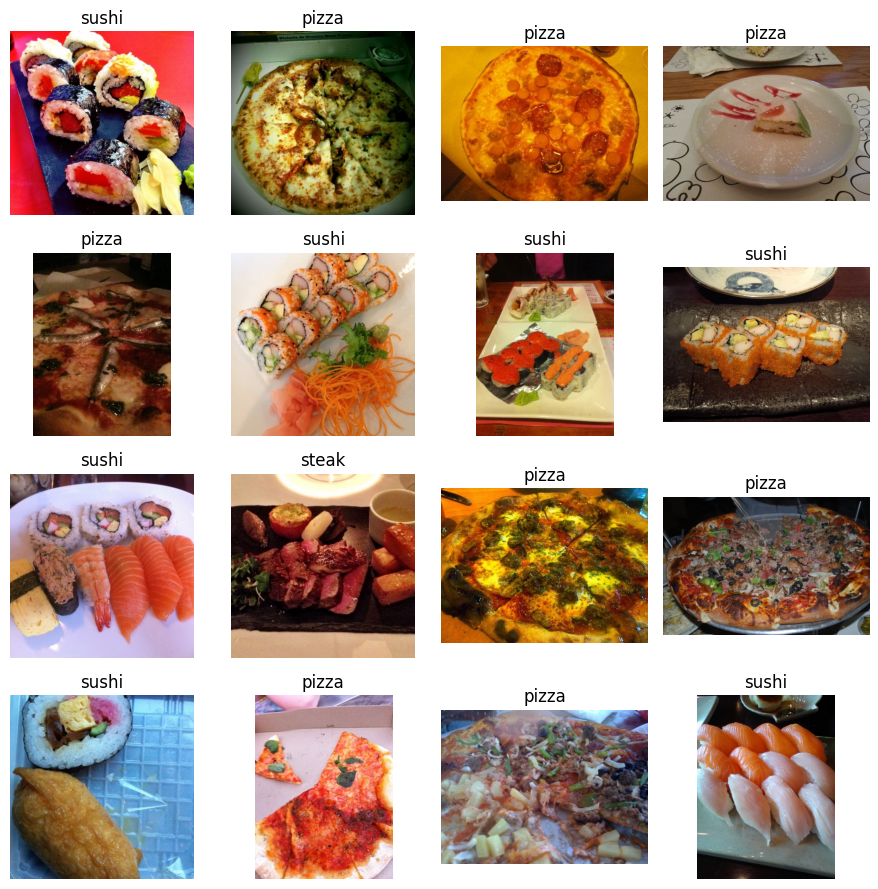

In [ ]:
# Let's viz few samples

import random
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))

fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
  random_image_path = random.choice(image_path_list)
  image_class = random_image_path.parent.stem
  ax = fig.add_subplot(rows, cols, i)
  img = Image.open(random_image_path)
  ax.imshow(img)
  ax.set_title(image_class)
  ax.axis('off')


plt.tight_layout()
plt.show()

**Transforming data**


    1. Turn it into tensors (numerical representations of our images).
    2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, DataLoader for short.


**torchvision.transforms** contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation.

Let's 3 things using transforms to get understanding of it

1. Reshape Image
2. Perform augmentation (Flip image)
3. Converting PIL image to tensor

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# we can compile all of those 3 steps into compose

train_transform = transforms.Compose([

    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=25),
    transforms.ToTensor()
])

test_transform = transforms.Compose([

    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


def plot_transformed_images(image_path, transform, n = 3):

  """
      Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random_image_path = random.sample(image_path, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)

      # Plotting Original Image
      ax[0].imshow(f)
      ax[0].set_title(f'Original Size {f.size}')
      ax[0].axis('off')

      # Plotting Transformer Image
      transformed_image = transform(f).permute(1 ,2, 0)  # (C,H,W) -> (H,W,C) | PyTorch default is [C, H, W] but Matplotlib is [H, W, C]
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Size {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class : {image_path.parent.stem}', fontsize = 16)

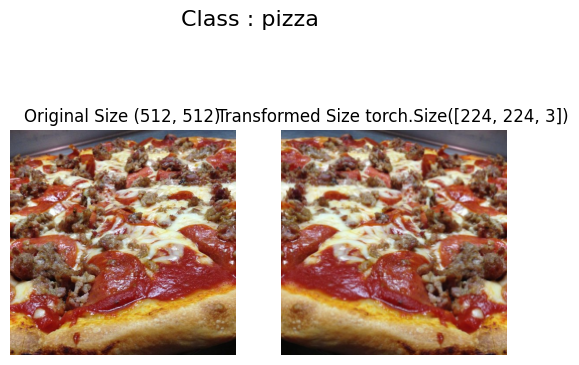

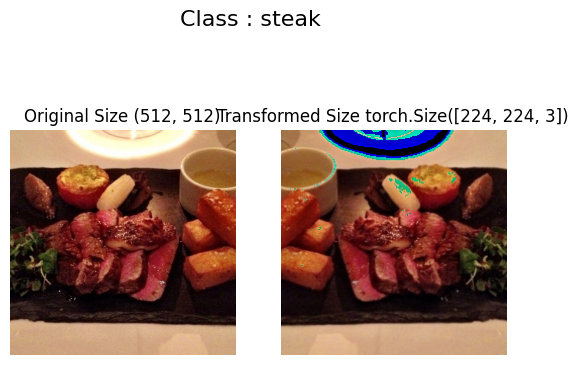

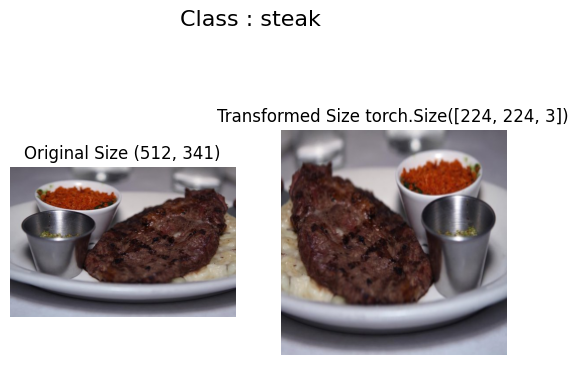

In [ ]:
plot_transformed_images(image_path_list, train_transform, 3)

(512, 384)


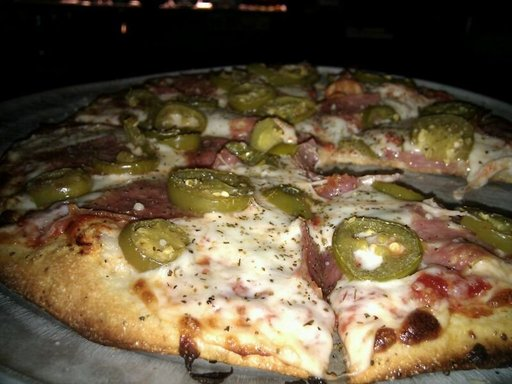

In [ ]:
print(Image.open(image_path_list[0]).size)
Image.open(image_path_list[0])

In [ ]:
print(train_transform(Image.open(image_path_list[0])).shape)
train_transform(Image.open(image_path_list[0]))

torch.Size([3, 224, 224])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
         ...,
         [0.2000, 0.2000, 0.2078,  ..., 0.2392, 0.2157, 0.1922],
         [0.1804, 0.1843, 0.1843,  ..., 0.2314, 0.2118, 0.1922],
         [0.1686, 0.1686, 0.1569,  ..., 0.2314, 0.2000, 0.1686]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
         ...,
         [0.2235, 0.2235, 0.2353,  ..., 0.2902, 0.2667, 0.2471],
         [0.2118, 0.2157, 0.2157,  ..., 0.2863, 0.2667, 0.2510],
         [0.2078, 0.2078, 0.1961,  ..., 0.2863, 0.2627, 0.2314]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

**Loading data into Dataset using `ImageFolder`**

In [ ]:
print(train_dir)
print(test_dir)

/content/drive/MyDrive/temp_dump/pizza_steak_sushi/train
/content/drive/MyDrive/temp_dump/pizza_steak_sushi/test


In [ ]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=train_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform=test_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: /content/drive/MyDrive/temp_dump/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=25, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

print(class_names)

['pizza', 'steak', 'sushi']


In [ ]:
img, label = train_data[0][0], train_data[0][1]

print(len(train_data), len(test_data))
print(img.shape)
print(img, label)

225 75
torch.Size([3, 224, 224])
tensor([[[0.0471, 0.0471, 0.0510,  ..., 0.0431, 0.0431, 0.0431],
         [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
         [0.0471, 0.0471, 0.0431,  ..., 0.0510, 0.0510, 0.0510],
         ...,
         [0.0392, 0.0353, 0.0353,  ..., 0.0706, 0.0706, 0.0745],
         [0.0353, 0.0353, 0.0353,  ..., 0.0667, 0.0706, 0.0706],
         [0.0353, 0.0353, 0.0314,  ..., 0.0627, 0.0627, 0.0627]],

        [[0.0275, 0.0314, 0.0314,  ..., 0.0196, 0.0196, 0.0196],
         [0.0314, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         [0.0275, 0.0314, 0.0275,  ..., 0.0235, 0.0275, 0.0235],
         ...,
         [0.0431, 0.0431, 0.0392,  ..., 0.0980, 0.0941, 0.0941],
         [0.0431, 0.0431, 0.0431,  ..., 0.0941, 0.0941, 0.0941],
         [0.0392, 0.0392, 0.0392,  ..., 0.0902, 0.0941, 0.0941]],

        [[0.0392, 0.0392, 0.0431,  ..., 0.0078, 0.0078, 0.0078],
         [0.0392, 0.0392, 0.0392,  ..., 0.0078, 0.0078, 0.0078],
         [0.0392, 0.0392,

**Loading Images into DataLoader**

Turning our `Dataset` into `DataLoader` makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a batch_size=1 (as we have very small data samples) and num_workers=1 (how many subprocesses will be created to load your data).

You can check avail worker on the system using `os.cpu_count()`

In [ ]:
os.cpu_count()

2

In [ ]:
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)


In [ ]:
print(next(iter(train_dataloader))[0].shape)
print(next(iter(train_dataloader))[1].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1])


In [ ]:
print(next(iter(test_dataloader))[0].shape)
print(next(iter(test_dataloader))[1].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1])


#### **Building Model**

Defining Same TinyVGG architecture

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,out_features=output_shape))

    def forward(self, x: torch.Tensor):

        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)

__Intution behind passing 54 * 54 in the final Linear Layer__

We are doing mainly two operation
1. Passing image through conv layer
2. Performing max pooling with kernal & stride 2

So after every pooling layer size will reduce

-

For a 2D convolution, the output spatial dimension is calculated as:

$$
\text{Output} = \left\lfloor \frac{N + 2P - K}{S} \right\rfloor + 1
$$

Where:
- \( N \) = input size (height or width)
- \( K \) = kernel size
- \( S \) = stride
- \( P \) = padding


How 56 × 56 usually appears :-

 1. Input image = 224 × 224
 2. First convolution `nn.Conv2d()` and after appling above formula for our model we get the same → hidden_units × 224 × 224  
 3. Applying Maxpooling `nn.MaxPool2d` and 224 → 112 (Pooling halves spatial size)
 4. Passing through Conv2D layers → same
 5. Applying `nn.MaxPool2d(2, 2)` and now we have 112 → 56
 6. Now we have 56 × 56


In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary

summary(model_0, input_size=[1,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─ReLU: 2-2                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 10, 224, 224]         910
│    └─ReLU: 2-4                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 10, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 10, 112, 112]         910
│    └─ReLU: 2-7                         [1, 10, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 10, 112, 112]         910
│    └─ReLU: 2-9                         [1, 10, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 10, 56, 56]           --
├─Sequentia

__Creating Training and Testing Loops__


1. train_step() → takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader
2. test_steo() → takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader
3. train() → performs 1. and 2. together for a given number of epochs and returns a results dictionary


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()
  train_loss, train_acc = 0 , 0

  for batch, (X, y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)


  '''
    We're dealing with batches in the DataLoader's, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch)
    and then adjust them at the end before we return them
  '''

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

  model.eval()
  test_loss, test_acc = 0 , 0

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        y_pred_class = y_pred.argmax(dim=1)
        test_acc += (y_pred_class == y).sum().item() / len(y_pred)

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")

        # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

#### **Training and Evaluation**

In [ ]:
from timeit import default_timer as timer

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1568 | train_acc: 0.2844 | test_loss: 1.0994 | test_acc: 0.2667
Epoch: 2 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1003 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1009 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1008 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0995 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0992 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1017 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333
Epoch: 12 | train_l

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
len(model_0_results['train_loss'])

20

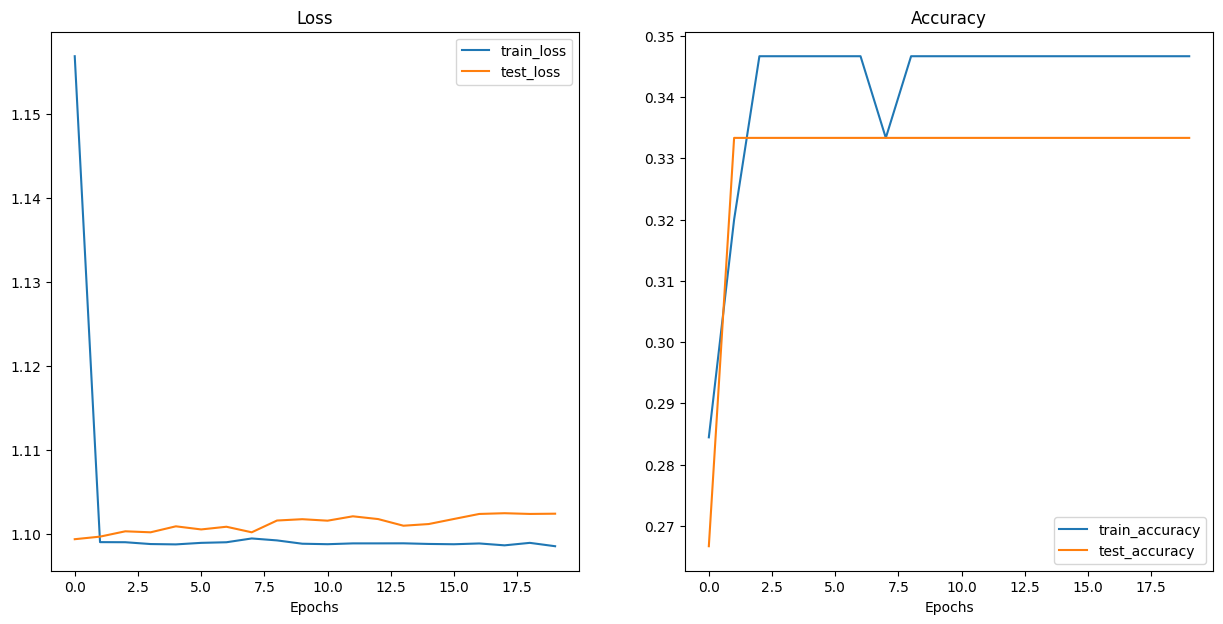

In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_loss_curves(model_0_results)

**Handling with overfitting**

*   Get more data
*   data augmentation
*   transfer learning
*   dropout layers
*   learning rate decy
*   early stoppping

**Handling with underfitting**

*   add more layers and units to model
*   tweak learning rate
*   Longer training
*   less regulaztion



#### **Inference**

In [ ]:
# Even though model isn't doing good, let's take an image of Pizza outside this dataset and
# run inference on that

import torchvision

Test_image = '/content/pleased-handsome-bearded-man-eats-delicious-pizza-dinner-feels-hungry-wears-round-glasses-shirt-eats-junk-food.jpg'
test_image_t = torchvision.io.read_image(Test_image)
test_image_t.shape

torch.Size([3, 5464, 8192])

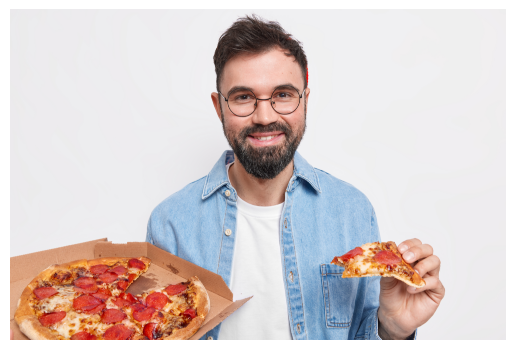

In [ ]:
# Current shape of image is [3, 5464, 8192] i.e., C×H×W but Matplotlib expect image shape of (H, W, C)
# so using permute change the position

plt.imshow(test_image_t.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
print(test_image_t.dtype)
print(next(model_0.parameters()).dtype)

torch.uint8
torch.float32


In [ ]:
test_image_t

tensor([[[235, 235, 235,  ..., 238, 238, 238],
         [235, 235, 235,  ..., 238, 238, 238],
         [235, 235, 235,  ..., 238, 238, 238],
         ...,
         [231, 230, 232,  ..., 234, 234, 234],
         [232, 232, 231,  ..., 234, 234, 234],
         [230, 232, 231,  ..., 234, 234, 234]],

        [[233, 233, 233,  ..., 238, 238, 238],
         [233, 233, 233,  ..., 238, 238, 238],
         [233, 233, 233,  ..., 238, 238, 238],
         ...,
         [160, 159, 161,  ..., 232, 232, 232],
         [161, 161, 160,  ..., 232, 232, 232],
         [162, 161, 160,  ..., 232, 232, 232]],

        [[236, 236, 236,  ..., 238, 238, 238],
         [236, 236, 236,  ..., 238, 238, 238],
         [236, 236, 236,  ..., 238, 238, 238],
         ...,
         [140, 139, 141,  ..., 235, 235, 235],
         [141, 141, 140,  ..., 235, 235, 235],
         [141, 141, 140,  ..., 235, 235, 235]]], dtype=torch.uint8)

Our custom_image tensor is of datatype torch.uint8 and its values are between [0, 255].

But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

In [ ]:
# So let's read image with float32 datatype

custom_image = torchvision.io.read_image(str(Test_image)).type(torch.float32)

custom_image = custom_image / 255.

print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")
print(custom_image)

Custom image shape: torch.Size([3, 5464, 8192])
Custom image dtype: torch.float32
tensor([[[0.9216, 0.9216, 0.9216,  ..., 0.9333, 0.9333, 0.9333],
         [0.9216, 0.9216, 0.9216,  ..., 0.9333, 0.9333, 0.9333],
         [0.9216, 0.9216, 0.9216,  ..., 0.9333, 0.9333, 0.9333],
         ...,
         [0.9059, 0.9020, 0.9098,  ..., 0.9176, 0.9176, 0.9176],
         [0.9098, 0.9098, 0.9059,  ..., 0.9176, 0.9176, 0.9176],
         [0.9020, 0.9098, 0.9059,  ..., 0.9176, 0.9176, 0.9176]],

        [[0.9137, 0.9137, 0.9137,  ..., 0.9333, 0.9333, 0.9333],
         [0.9137, 0.9137, 0.9137,  ..., 0.9333, 0.9333, 0.9333],
         [0.9137, 0.9137, 0.9137,  ..., 0.9333, 0.9333, 0.9333],
         ...,
         [0.6275, 0.6235, 0.6314,  ..., 0.9098, 0.9098, 0.9098],
         [0.6314, 0.6314, 0.6275,  ..., 0.9098, 0.9098, 0.9098],
         [0.6353, 0.6314, 0.6275,  ..., 0.9098, 0.9098, 0.9098]],

        [[0.9255, 0.9255, 0.9255,  ..., 0.9333, 0.9333, 0.9333],
         [0.9255, 0.9255, 0.9255,  ..., 0

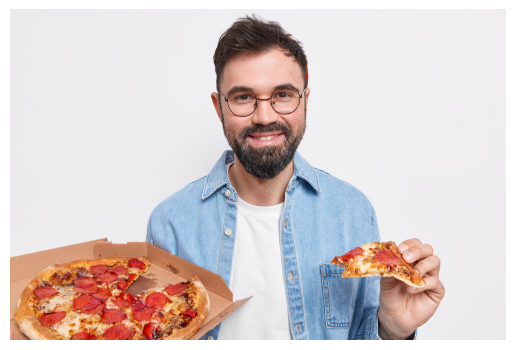

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# Now check with shape [Model was trained on 224 * 224]

print(custom_image.shape)

custom_transform = transforms.Compose([transforms.Resize((224, 224))])
custom_image_transformed = custom_transform(custom_image)

print(custom_image_transformed.shape)

torch.Size([3, 5464, 8192])
torch.Size([3, 224, 224])


In [ ]:
# Adding batch as model was trained on the batch size right ?
# otherwise you'll get error like : RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 31360x3)


print(custom_image_transformed.shape)
custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
print(custom_image_transformed.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
model_0.eval()
with torch.inference_mode():
  custom_image_pred = model_0(custom_image_transformed.to(device))

__While doing inference classical and most common deep learning and PyTorch issues__

    1. Wrong datatypes - our model expects torch.float32 where our original custom image was uint8.
    2. Wrong device - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
    3. Wrong shapes - our model expected an input image of shape [N, C, H, W] or [batch_size, color_channels, height, width] whereas our custom image tensor was of shape [color_channels, height, width].


In [ ]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1) # logits -> probability
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1) # probability -> actual class


print(f"Prediction logits: {custom_image_pred}")
print(f"Prediction probabilities: {custom_image_pred_probs}")
print(f"Prediction label: {class_names[custom_image_pred_label]}")

Prediction logits: tensor([[ 0.0340, -0.0046, -0.0454]], device='cuda:0')
Prediction probabilities: tensor([[0.3465, 0.3334, 0.3201]], device='cuda:0')
Prediction label: pizza


If we check the custom_image_pred_probs, we'll notice that the model gives almost equal weight (the values are similar) to every class.

Having prediction probabilities this similar could mean a couple of things:

    1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
    2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.


Our case is number 2, since our model is poorly trained, it is basically guessing the prediction.

__Let's put that all inference logic into simple module__

In [ ]:
"""Makes a prediction on a target image and plots the image with its prediction."""


def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.

    if transform is not None:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():

        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))


    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)


    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

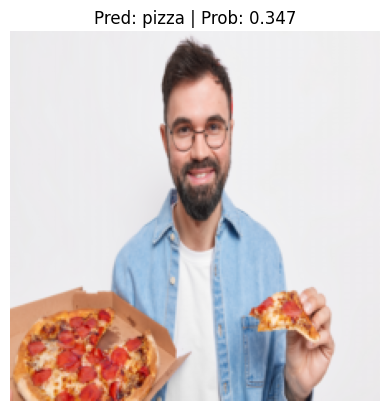

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path=Test_image,
                    class_names=class_names,
                    transform=custom_transform,
                    device=device)

------

**Reading References:**




*   [TrivialAugment](https://arxiv.org/pdf/2103.10158)
*   [Illustration of transforms](https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html)
*   [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)

